## Linear Support Vector Regression

In [1]:
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])

/var/folders/c2/h79928n92258kzkwtzbxjbj80000gn/T/ipykernel_25829/265178491.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-whitegrid'])


In [3]:
from sklearn.svm import SVR, SVC # suport vector regression / classification
from sklearn.datasets import load_diabetes
from sklearn.datasets import load_breast_cancer, load_iris, load_wine
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE # 2차원으로 축소, 주로 시각화에 활용(비슷한 구조끼리 데이터를 정리하여 구조 이해 도움)

In [6]:

#from sklearn.datasets import load_boston
import pickle
with open('./boston.pickle', 'rb') as f:
    boston = pickle.load(f)

print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])


### 보스턴 주택 가격

In [7]:
x = boston.data
y = boston.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=123)

In [8]:
model = SVR(kernel='linear')
model.fit(x_train, y_train)

SVR(kernel='linear')

In [9]:
print(f'Train Data Score: {model.score(x_train, y_train)}')
print(f'Test Data Score: {model.score(x_test, y_test)}')

Train Data Score: 0.7155065522120606
Test Data Score: 0.638039631835579


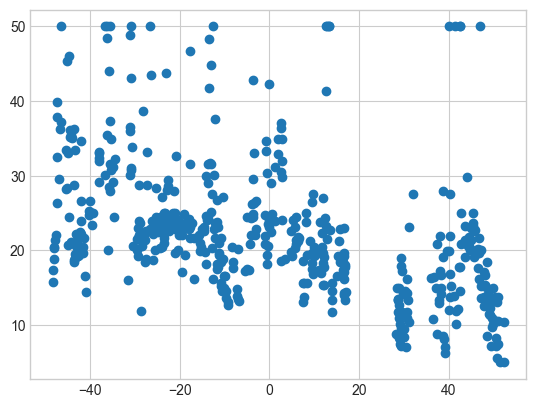

In [10]:
x_comp = TSNE(n_components=1).fit_transform(x) # 저차원 변환. 13개의 feature를 1개로만듦
plt.scatter(x_comp, y); # 시각화

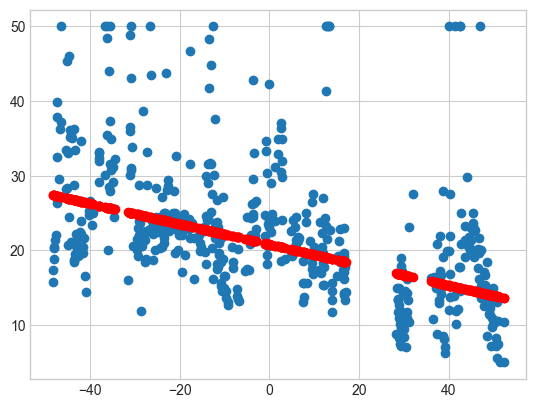

In [11]:
model.fit(x_comp, y)
predict = model.predict(x_comp)
plt.scatter(x_comp, y)
plt.scatter(x_comp, predict, color = 'r')

In [13]:
#pipeline 생성 (SS > SVR)
estimator = make_pipeline(StandardScaler(), SVR(kernel = 'linear'))

result = cross_validate(
    estimator=estimator,
    X=x, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
    )

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.4s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    2.9s finished


{'fit_time': array([0.01367021, 0.00875807, 0.00707626, 0.00623798, 0.00640512]),
 'score_time': array([0.00081897, 0.00126982, 0.00072908, 0.00065565, 0.00079083]),
 'test_score': array([0.76908568, 0.72180141, 0.56428426, 0.14083339, 0.07810211])}

In [14]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', SVR(kernel='linear'))])

param_grid = [{'model__gamma': ['scale', 'auto'],
               'model__C': [1.0, 0.1, 0.01],
               'model__epsilon': [1.0, 0.1, 0.01]}] #margin의 폭 지정(값이 커질수록 폭도 커지게된다. -> hard vs soft)

gs = GridSearchCV(
    estimator=pipe, param_grid = param_grid,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
    )

gs.fit(x, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVR(kernel='linear'))]),
             n_jobs=8,
             param_grid=[{'model__C': [1.0, 0.1, 0.01],
                          'model__epsilon': [1.0, 0.1, 0.01],
                          'model__gamma': ['scale', 'auto']}],
             verbose=True)

In [15]:
gs.best_estimator_ #가장 성능이 좋은 모델

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', SVR(C=0.1, epsilon=1.0, kernel='linear'))])

### 당뇨병

In [16]:
x, y = load_diabetes(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [32]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [33]:
model = SVR(kernel='rbf')
model.fit(x_train,y_train)

SVR()

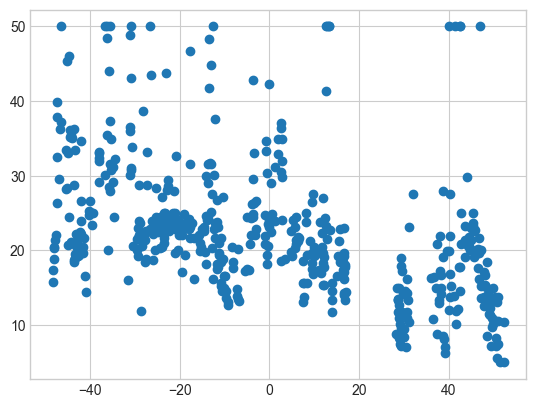

In [34]:
#TSNE를 이용해 저차원 변경 후 시각화
x_comp = TSNE(n_components=1).fit_transform(x) 
plt.scatter(x_comp, y); 

In [35]:
#cross_validate를 이용한 기본 model 성능 측정
#pipeline 생성 (SS > SVR)
estimator = make_pipeline(StandardScaler(), SVR(kernel = 'linear'))

cross_validate(
    estimator=estimator,
    X=x, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
    )

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.00792503, 0.00852489, 0.00808978, 0.00591421, 0.00668907]),
 'score_time': array([0.00092387, 0.00113106, 0.00099111, 0.00072789, 0.0006628 ]),
 'test_score': array([0.76908568, 0.72180141, 0.56428426, 0.14083339, 0.07810211])}

In [37]:
#GridSearchCV를 이용한 최적의 파라미터 추정
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', SVR(kernel='linear'))])

param_grid = [{'model__kernel': ['rbf', 'polynomial', 'sigmoid'],
               'model__gamma': ['scale', 'auto'],
               'model__C': [1.0, 0.1, 0.01],
               'model__epsilon': [1.0, 0.1, 0.01]}] #margin의 폭 지정(값이 커질수록 폭도 커지게된다. -> hard vs soft)

gs = GridSearchCV(
    estimator=pipe, param_grid = param_grid,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
    )

gs.fit(x, y)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


/Users/heojeongyun/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/heojeongyun/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/heojeongyun/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py", line 406, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/heojeongyun/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py", line

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVR(kernel='linear'))]),
             n_jobs=8,
             param_grid=[{'model__C': [1.0, 0.1, 0.01],
                          'model__epsilon': [1.0, 0.1, 0.01],
                          'model__gamma': ['scale', 'auto'],
                          'model__kernel': ['rbf', 'polynomial', 'sigmoid']}],
             verbose=True)

In [38]:
gs.best_estimator_ #가장 성능이 좋은 모델

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', SVR(C=0.1, epsilon=0.01, kernel='sigmoid'))])

## Kernel SVR

### 보스턴 주택 가격

In [21]:
x = boston.data
y = boston.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=123)

In [22]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [23]:
model = SVR(kernel='rbf')
model.fit(x_train, y_train)

SVR()

In [24]:
print(f'Train Data Score: {model.score(x_train, y_train)}')
print(f'Test Data Score: {model.score(x_test, y_test)}')

Train Data Score: 0.6711049067426176
Test Data Score: 0.6042588074212358


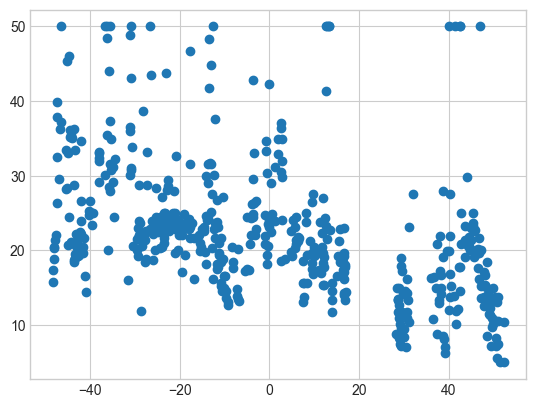

In [25]:
x_comp = TSNE(n_components=1).fit_transform(x)
plt.scatter(x_comp, y)

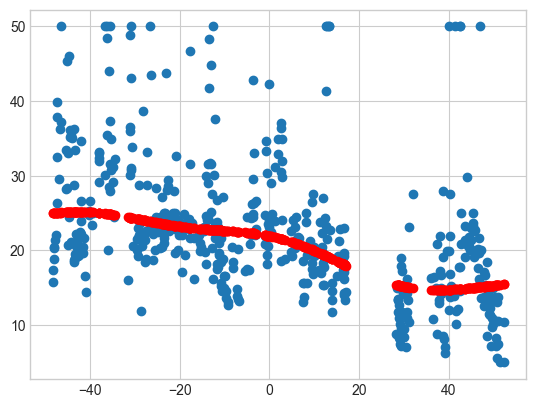

In [26]:
model.fit(x_comp, y)
predict = model.predict(x_comp)
plt.scatter(x_comp, y)
plt.scatter(x_comp, predict, color = 'r');

In [27]:
estimator = make_pipeline(StandardScaler(), SVR(kernel = 'rbf'))

cross_validate(
    estimator=estimator,
    x=x, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
    )

TypeError: cross_validate() got an unexpected keyword argument 'x'

In [28]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', SVR(kernel='rbf'))])

param_grid = [{'model__kernel': ['rbf', 'polynomial', 'sigmoid']}]

gs = GridSearchCV(
    estimator=pipe, param_grid = param_grid,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
    )

gs.fit(x, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/heojeongyun/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/heojeongyun/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/heojeongyun/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py", line 406, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/heojeongyun/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py", line 18

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVR())]),
             n_jobs=8,
             param_grid=[{'model__kernel': ['rbf', 'polynomial', 'sigmoid']}],
             verbose=True)

In [29]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVR())])

In [30]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', SVR(kernel='rbf'))])

param_grid = [{'model__gamma': ['scale', 'auto'],
'model__C': [1.0, .1, .01],
'model__epsilon': [1, .1, .01]}]

gs = GridSearchCV(
    estimator=pipe, param_grid = param_grid,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
    )

gs.fit(x, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVR())]),
             n_jobs=8,
             param_grid=[{'model__C': [1.0, 0.1, 0.01],
                          'model__epsilon': [1, 0.1, 0.01],
                          'model__gamma': ['scale', 'auto']}],
             verbose=True)

In [31]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVR(epsilon=0.01))])

### 당뇨병

In [ ]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = SVR(kernel='rbf')
model.fit(X_train, y_train)

In [ ]:
X_comp = TSNE(n_components=1).fit_transform(X)
plt.scatter(X_comp, y)

In [ ]:
model.fit(X_comp, y)
predict = model.predict(X_comp)
plt.scatter(X_comp, y)
plt.scatter(X_comp, predict, color = 'r');

In [ ]:
estimator = make_pipeline(StandardScaler(), SVR(kernel = 'rbf'))

cross_validate(
    estimator=estimator,
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
    )

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', SVR(kernel='rbf'))])

param_grid = [{'model__kernel': ['rbf', 'polynomial', 'sigmoid']}]

gs = GridSearchCV(
    estimator=pipe, 
    param_grid = param_grid,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
    )

gs.fit(X, y)

In [ ]:
gs.best_estimator_

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', SVR(kernel='sigmoid'))])

param_grid = [{'model__gamma': ['scale', 'auto'],
'model__C': [1.0, .1, .01],
'model__epsilon': [1, .1, .01]}]

gs = GridSearchCV(
    estimator=pipe, param_grid = param_grid,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
    )

gs.fit(X_train, y_train)

In [ ]:
gs.best_estimator_

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', SVR(kernel='rbf'))])

param_grid = [{'model__kernel': ['rbf', 'polynomial', 'sigmoid'],
               'model__gamma': ['scale', 'auto'],
               'model__C': [1.0, .1, .01],
               'model__epsilon': [1, .1, .01]}]


gs = GridSearchCV(
    estimator=pipe, 
    param_grid = param_grid,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
    )

gs.fit(X_train, y_train)

In [ ]:
gs.best_estimator_

In [ ]:
model = gs.best_estimator_
model.fit(X_train, y_train)

In [ ]:
print(f'Train Data Score: {model.score(X_train, y_train)}')
print(f'Test Data Score: {model.score(X_test, y_test)}')

## Linear SVC

### 유방암

In [ ]:
x, y = load_breast_cancer(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
model = SVC(kernel='linear')
model.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
print(f'Train Data Score: {model.score(x_train, y_train)}')
print(f'Test Data Score: {model.score(x_test, y_test)}')

학습 데이터 점수: 0.9824175824175824
평가 데이터 점수: 0.9824561403508771


In [ ]:
def make_meshgrid(x, y, h=.2):
  x_min, x_max = x.min()-1, x.max()+1
  y_min, y_max = y.min()-1, y.max()+1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))
  
  return xx, yy

In [ ]:
def plot_contours(clf, xx, yy, --params):
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  out = plt.contourf(xx, yy, Z, --params)

  return out

In [ ]:
x_comp = TSNE(n_components=2).fit_transform(x) # 저차원 변환
x0, x1 = x_comp[:, 0], x_comp[:, 1]
xx, yy = make_meshgrid(x0, x1)

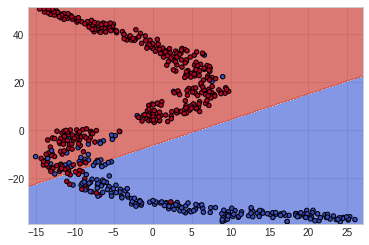

In [ ]:
model.fit(x_comp, y)

plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.7)
plt.scatter(x0, x1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [ ]:
estimator = make_pipeline(StandardScaler(), SVC(kernel = 'linear'))

cross_validate(
    estimator=estimator,
    x=x, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
    )

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.00864482, 0.01121259, 0.00668645, 0.00618744, 0.00621319]),
 'score_time': array([0.0027051 , 0.00099158, 0.00087452, 0.00092196, 0.00085235]),
 'test_score': array([0.96491228, 0.98245614, 0.96491228, 0.96491228, 0.98230088])}

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', SVC(kernel='linear'))])

param_grid = [{'model__gamma': ['scale', 'auto'],
               'model__C':[1.0, 0.1, 0.01]}]

gs = GridSearchCV(
    estimator=pipe, 
    param_grid = param_grid,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
    )

gs.fit(x, y)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='linear', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=

In [ ]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [ ]:
model = gs.best_estimator_
model.fit(x_comp, y)

plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.7)
plt.scatter(x0, x1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [ ]:
model.score(x_comp, y)

### 붓꽃

## Kernel SVC

### 유방암

In [ ]:
x, y = load_breast_cancer(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
model = SVC(kernel='rbf')
model.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
print(f'Train Data Score: {model.score(x_train, y_train)}')
print(f'Test Data Score: {model.score(x_test, y_test)}')

학습 데이터 점수: 0.9846153846153847
평가 데이터 점수: 0.9912280701754386


In [ ]:
x_comp = TSNE(n_components=2).fit_transform(x)
x0, x1 = x_comp[:, 0], x_comp[:, 1]
xx, yy = make_meshgrid(x0, x1)

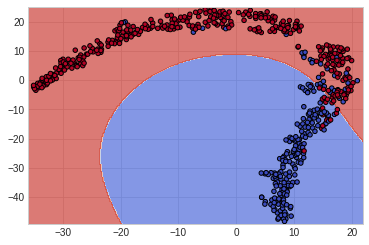

In [ ]:
model.fit(x_comp, y)

plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.7)
plt.scatter(x0, x1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [ ]:
estimator = make_pipeline(StandardScaler(), SVC(kernel = 'rbf'))

cross_validate(
    estimator=estimator,
    x=x, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
    )

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.1s finished


{'fit_time': array([0.00752592, 0.0070262 , 0.01560569, 0.01018143, 0.00756121]),
 'score_time': array([0.0016675 , 0.00528979, 0.0018239 , 0.00907063, 0.00221181]),
 'test_score': array([0.97368421, 0.95614035, 1.        , 0.96491228, 0.97345133])}

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', SVR(kernel='rbf'))])

param_grid = [{'model__kernel': ['rbf', 'polynomial', 'sigmoid']}]

gs = GridSearchCV(
    estimator=pipe, 
    param_grid = param_grid,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
    )

gs.fit(x, y)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done  12 out of  15 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    0.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        SVR(C=1.0, cache_size=200, coef0=0.0,
                                            degree=3, epsilon=0.1,
                                            gamma='scale', kernel='rbf',
                                            max_iter=-1, shrinking=True,
                                            tol=0.001, verbose=False))],
                                verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'model__kernel': ['rbf', 'polynomial', 'sigmoid']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
   

In [ ]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

### 붓꽃

In [ ]:
x, y = load_iris(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

# best model : "rbf"

# 정리



## 와인 DataSet을 이용해 다음과 같은 과정을 수행해 보세요
- StandardScaler 적용후 SVC를 이용해 model 분류 (kenel = rbf)


In [ ]:
x, y = load_wine(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

In [ ]:
x.shape

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler .transform(x_train) # fit은 위 코드에서 수행했으므로 transform만 실행
x_test = scaler.transform(x_test)

In [ ]:
model = SVC(kernel='rbf')
model.fit(x_train, y_train)

In [ ]:
print(f'Train Data Score: {model.score(x_train, y_train)}')
print(f'Test Data Score: {model.score(x_test, y_test)}')
# 13차원의 데이터를 이용해 score 측정

In [ ]:
x_comp = TSNE(n_components=2).fit_transform(x) # 저차원 변환
X0, X1 = x_comp[:, 0], x_comp[:, 1]
xx, yy = make_meshgrid(X0, X1)

In [ ]:
model.fit(x_comp, y)

plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.7)
plt.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [ ]:
estimator = make_pipeline(StandardScaler(), SVC(kernel = 'rbf'))

cross_validate(
    estimator=estimator,
    X=x, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
    )

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', SVR(kernel='rbf'))])

param_grid = [{'model__kernel': ['rbf', 'polynomial', 'sigmoid']}]

gs = GridSearchCV(
    estimator=pipe, 
    param_grid = param_grid,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
    )

gs.fit(x, y)

In [ ]:
gs.best_estimator_

In [ ]:
model = gs.best_estimator_
model.fit(x_comp, y)
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.7)
plt.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [ ]:
model.score(x_comp, y)
# TSNE 을 이용해 저차원(2차원)으로 압축후 model score 측정 